In [1]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

In [2]:
#=====================================
# Function declarations
#=====================================

#Function to create point cloud file
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3),colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
    for i in range(0,reduce_factor):
        #Check if image is color or grayscale
        if len(image.shape) > 2:
            row,col = image.shape[:2]
        else:
            row,col = image.shape

        image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
    return image


In [3]:


#=========================================================
# Stereo 3D reconstruction 
#=========================================================

#Load camera parameters
ret = np.load('./calibration/camera_params/ret.npy')
K = np.load('./calibration/camera_params/K.npy')
dist = np.load('./calibration/camera_params/dist.npy')

#Specify image paths
img_path1 = 'Left.jpg'
img_path2 = 'Right.jpg'

#Load pictures
img_1 = cv2.imread(img_path1)
img_2 = cv2.imread(img_path2)

#Get height and width. Note: It assumes that both pictures are the same size. They HAVE to be same size and height. 
h,w = img_2.shape[:2]

#Get optimal camera matrix for better undistortion 
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

#Undistort images
img_1_undistorted = cv2.undistort(img_1, K, dist, None, new_camera_matrix)
img_2_undistorted = cv2.undistort(img_2, K, dist, None, new_camera_matrix)

#Downsample each image 3 times (because they're too big)
img_1_downsampled = downsample_image(img_1_undistorted,3)
img_2_downsampled = downsample_image(img_2_undistorted,3)

#cv2.imwrite('undistorted_left.jpg', img_1_downsampled)
#cv2.imwrite('undistorted_right.jpg', img_2_downsampled)


#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
    numDisparities = num_disp,
    blockSize = 5,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 2,
    P1 = 8*3*win_size**2,#8*3*win_size**2,
    P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

#Generate  point cloud. 
print ("\nGenerating the 3D map...")

#Get new downsampled width and height 
h,w = img_2_downsampled.shape[:2]

#Load focal length. 
focal_length = np.load('./calibration/camera_params/FocalLength.npy')

#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
Q = np.float32([[1,0,0,-w/2.0],
                [0,-1,0,h/2.0],
                [0,0,0,-focal_length],
                [0,0,1,0]])

#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
                [0,-1,0,0],
                [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
                [0,0,0,1]])

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file
output_file = 'reconstructed.ply'

#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)

FileNotFoundError: [Errno 2] No such file or directory: './calibration/camera_params/ret.npy'

In [4]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 

In [5]:
#Specify image paths
img_path1 = 'Left.jpg'
img_path2 = 'Right.jpg'

#Load pictures
img_1 = cv2.imread(img_path1)
img_2 = cv2.imread(img_path2)
 
# Convert image to RGB
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

# Convert image to gray scale
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)

In [6]:
orb = cv2.ORB_create()

keypoints1, descriptor1 = orb.detectAndCompute(img_1_gray, None)
keypoints2, descriptor2 = orb.detectAndCompute(img_2_gray, None)

In [7]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the test image
matches = bf.match(descriptor1, descriptor2)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)



In [8]:
list_kp1 = [keypoints1[mat.queryIdx].pt for mat in matches] 
list_kp2 = [keypoints2[mat.trainIdx].pt for mat in matches]
#projPoints1 = np.int32(list_kp1)
#projPoints2 = np.int32(list_kp2)
projPoints1 = cv2.UMat(np.array([list_kp1]))
projPoints2 = cv2.UMat(np.array([list_kp2]))
#projPoints1 = [cv2.UMat(x) for x in list_kp1]
#projPoints2 = [cv2.UMat(x) for x in list_kp2]

In [9]:
# Load camera parameters
# get projection matrix in the new (rectified) coordinate systems for the first camera
# and projection matrix in the new (rectified) coordinate systems for the second camera.
line = './calibration/camera_params/stereo_params/'
ret = np.load(line + 'ret.npy')
K_left = np.load(line + 'K_left.npy')
K_right = np.load(line + 'K_right.npy')
dist_left = np.load(line + 'dist_left.npy')
dist_right = np.load(line + 'dist_right.npy')
R = np.load(line + 'R.npy')
T = np.load(line + 'T.npy')
image_size = np.load(line + 'image_size.npy')
image_size = (image_size[0], image_size[1])
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(cameraMatrix1 = K_left, 
                                                  cameraMatrix2 = K_right, 
                                                  distCoeffs1 = dist_left, 
                                                  distCoeffs2 = dist_right, 
                                                  imageSize = image_size, 
                                                  R = R, 
                                                  T = T,
                                                  alpha=1)


In [10]:
points4D = cv2.triangulatePoints(P1, P2, projPoints1, projPoints2) 

In [11]:
points4D.get()[:3].T

array([[0.06484266, 0.9978352 , 0.01096975],
       [0.06492694, 0.99782971, 0.01097107],
       [0.06510717, 0.99781798, 0.01097015],
       [0.02621492, 0.99959587, 0.01099408],
       [0.06503578, 0.99782263, 0.01097007],
       [0.02622555, 0.99959559, 0.01099416],
       [0.05324044, 0.99851955, 0.01114325],
       [0.05394587, 0.99848173, 0.01113875],
       [0.05660823, 0.99833615, 0.01097486],
       [0.06518238, 0.99781273, 0.01100089],
       [0.05398135, 0.99847982, 0.01113872],
       [0.05659253, 0.99833704, 0.01097434],
       [0.06519775, 0.99781173, 0.01100003],
       [0.07458706, 0.99715433, 0.01095495],
       [0.06487806, 0.9978329 , 0.01097009],
       [0.06504334, 0.99782213, 0.01097053],
       [0.06506245, 0.99782089, 0.01097051],
       [0.02620434, 0.99959614, 0.01099453],
       [0.02648525, 0.99958849, 0.01101712],
       [0.06082278, 0.99808827, 0.01097275],
       [0.0544247 , 0.99845543, 0.01116711],
       [0.04218618, 0.9990452 , 0.01135864],
       [0.

In [ ]:
R1, R2, P1, P2, Q = cv2.stereoRectify(cameraMatrix1 = K_left, 
                                      distCoeffs1 = dist_left,
                                      cameraMatrix2 = K_right, 
                                      distCoeffs2 = dist_right, 
                                      imageSize = image_size, 
                                      R = R, 
                                      T = T)

In [24]:
colors = np.zeros(np.shape(points4D.get()[:3].T))
for i in range(len(colors)):
    colors[i] = [0, 255, 0]

In [26]:
output_points = points4D.get()[:3].T
output_colors = colors

#Define name for output file
output_file = 'Triangulate.ply'

#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


 Creating the output file... 



Number of Keypoints Detected In The Training Image:  499
Number of Keypoints Detected In The Query Image:  500


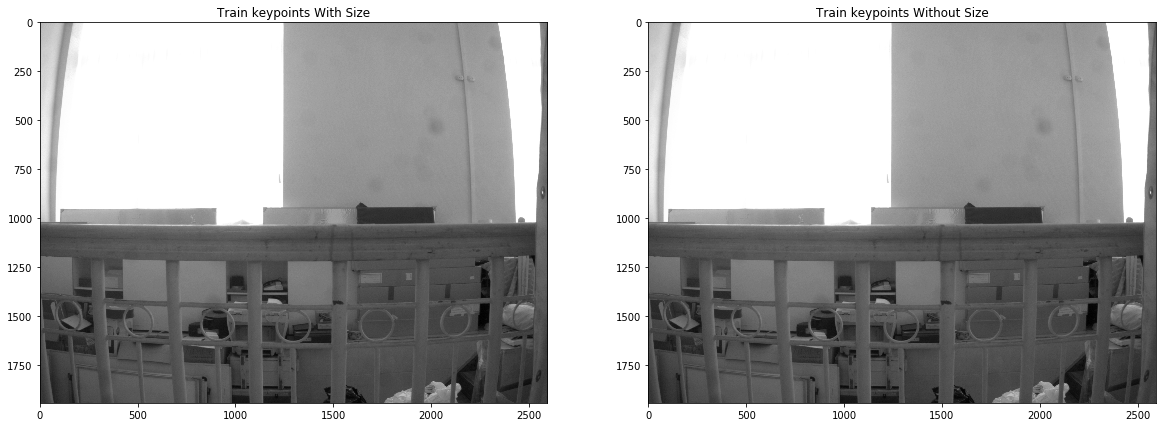

In [35]:


train_keypoints, train_descriptor = orb.detectAndCompute(img_1_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(img_2_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)
my_key_points = np.copy(test_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')


# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))